In [ ]:
!pip install pyarrow
!pip install pandas==1.3.5
!pip install --upgrade scikit-learn

In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [107]:
import pickle

In [3]:
pd.__version__

'2.1.4'

In [4]:
df = pd.read_parquet('../data/green_tripdata_2024-01.parquet')

In [5]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [6]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [7]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [8]:
df[df.trip_type == 2]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
36,2,2024-01-01 00:15:43,2024-01-01 00:15:51,N,5.0,61,61,2.0,0.00,22.00,...,0.0,0.00,0.00,NaN,1.0,23.00,2.0,2.0,0.00,0.133333
45,2,2024-01-01 00:34:56,2024-01-01 00:34:57,N,5.0,66,264,2.0,0.00,50.00,...,0.0,10.20,0.00,NaN,1.0,61.20,1.0,2.0,0.00,0.016667
56,2,2024-01-01 00:52:23,2024-01-01 01:07:39,N,5.0,74,127,1.0,5.76,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,15.266667
58,2,2024-01-01 00:55:10,2024-01-01 01:22:19,N,5.0,189,91,2.0,5.04,30.99,...,0.0,6.40,0.00,NaN,1.0,38.39,1.0,2.0,0.00,27.150000
59,2,2024-01-01 00:56:37,2024-01-01 00:56:42,N,5.0,173,173,1.0,0.00,15.00,...,0.0,0.00,0.00,NaN,1.0,16.00,1.0,2.0,0.00,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2,2024-01-31 22:10:36,2024-01-31 22:16:46,N,5.0,42,74,1.0,1.03,8.00,...,0.0,0.00,0.00,NaN,1.0,9.00,2.0,2.0,0.00,6.166667
53110,2,2024-01-31 23:19:51,2024-01-31 23:52:04,N,5.0,25,162,2.0,8.32,40.00,...,0.0,2.00,6.94,NaN,1.0,52.69,1.0,2.0,2.75,32.216667
53123,2,2024-01-31 23:57:29,2024-02-01 00:24:07,N,5.0,181,100,2.0,6.16,60.00,...,0.0,12.75,0.00,NaN,1.0,76.50,1.0,2.0,2.75,26.633333
53133,2,2024-01-31 23:19:14,2024-01-31 23:19:27,N,5.0,181,181,2.0,0.00,74.00,...,0.0,10.00,0.00,NaN,1.0,85.00,1.0,2.0,0.00,0.216667


In [31]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
50%         11.400000
95%         33.683333
98%         46.816667
99%         59.825000
max       1438.983333
Name: duration, dtype: float64

In [63]:
df = df[(df.duration >= 1) & (df.duration <= 50)]

In [64]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [65]:
df[categorical] = df[categorical].astype(str)

In [66]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [67]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [68]:
target = 'duration'
y_train = df[target].values

In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [70]:
y_pred = lr.predict(X_train)

In [71]:
mean_squared_error(y_train, y_pred, squared=True)

43.17180494161362

/var/folders/k9/x9kpxf8j1031vym13wtllsfm0000gn/T/ipykernel_27256/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/Users/winyter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/k9/x9kpxf8j1031vym13wtllsfm0000gn/T/ipykernel_27256/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `dis

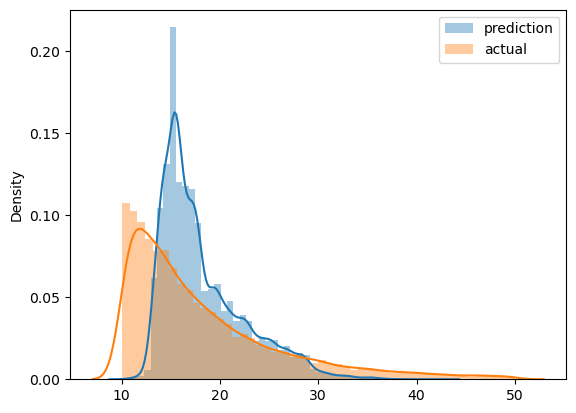

In [72]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [74]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 50)]
    
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    
    df[categorical] = df[categorical].astype(str)
    
    return df

In [77]:
df_train = read_dataframe('../data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2024-02.parquet')

In [79]:
len(df_train), len(df_val)

(54016, 51143)

In [80]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [81]:
categorical = ['PU_DO']
numerical = ['trip_distance']

In [82]:
dv = DictVectorizer()

In [84]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [85]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [86]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [87]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.4693762190259765

In [106]:
lr = Ridge(alpha=0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.449730617310565

In [108]:
with open('./lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)